In [3]:
import findspark
import streamlit
import setuptools

findspark.init()

import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello")

/usr/local/lib/python3.12/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/25 09:20:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/25 09:20:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load the Data

In [4]:
ratings = spark.read.csv("ratings.csv",header=True)
movies = spark.read.csv("movies.csv",header=True)

In [5]:
from pyspark.sql.functions import col

ratings = ratings \
            .withColumn("userId", col("userId").cast('integer'))\
            .withColumn("movieId", col("movieId").cast("integer"))\
            .withColumn("rating", col("rating").cast("float"))\
            .drop('timestamp')

ratings.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
+------+-------+------+
only showing top 5 rows



# Recommendation Systems

- Recommender System is an information filtering tool that seeks to predict which product a user will like, and based on that, recommends a few products to the users. 
- The two widely used approaches for building a recommender system are the Content Based Filtering (CBF) and Collaborative Filtering (CF)

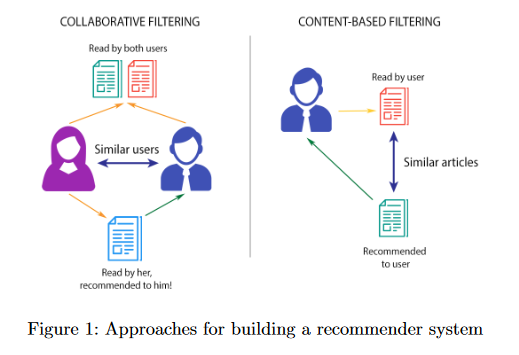

There are two ways to gather user preference data to recommend items:
- **explicit** ratings from a user, typically on a concrete rating scale (such as rating a movie from one to five stars)
    - making it easier to make extrapolations from data to predict future ratings
    - However, the drawback with explicit data is that it puts the responsibility of data collection on the user, who may not want to take time to enter ratings.
- **implicit** data is easy to collect in large quantities without any extra effort on the part of the user
    - it is much more difficult to work with

### Content Based (CBF) vs Collaborative Filtering (CF)
**Content Based Filtering (CBF)**
- Recommend Items similar to the items previously liked by the user.
- Based on the description of the items and the user's preferences.
- It treats recommendation as a user-specific classificatoin via a classifer

**Collabortive Filtering (CF)**
- Aggregates past behaviour of users.
- Recommends based on the items liked by a set of users who like and dislike similar items to the user under consideration.
- Also called *User Based CF*.
- The *Item-Based CF* recommends an item based on similarity between items liked by the user and other items. 
- CF systems are more domimant because CBF would require everyones preferences which aren't easy to gather.
- CF allows for two approaches **Memory Based** and **Model-Based**

# Memory-Based Recommendation

## Pearsons Rank

In [6]:
user_ratings = ratings.join(movies, on='movieId')
user_ratings = user_ratings.toPandas()
user_ratings = user_ratings.pivot_table(index=['userId'], columns=['title'], values=['rating'])

# compute the similarity
user_distances_pearson = user_ratings.transpose().corr(method="pearson")

# KNN
k = 5
user_distances_pearson = user_distances_pearson\
                            .dropna(axis=0, thresh=k+1)\
                            .dropna(axis=1, thresh=k+1)
# make the matrix square
user_distances_pearson = user_distances_pearson.loc[user_distances_pearson.columns]

# from PCC ranging from [-1, +1] to distance [0,2]
user_distances_pearson = 1.0 - user_distances_pearson
# floating point precison issue 
user_distances_pearson[user_distances_pearson < 0] = 0

### KNN

In [7]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# define the model
model_knn = NearestNeighbors(metric="precomputed", algorithm="brute", n_neighbors=k, n_jobs=-1)

# fit the model
value_matrix = csr_matrix(user_distances_pearson.fillna(0).values)
model_knn.fit(value_matrix)

# make predicions
similarity, indexes = model_knn.kneighbors(value_matrix, n_neighbors=k)

/usr/local/lib/python3.12/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


- The neighbours listed in the array are not ids, but integer indexes to the user distances pearson dataframe. We need to get the neighbours’s user ids ourselves.

In [8]:
import pandas as pd
neighbourhoods_pearson = pd.DataFrame(
    {'neighbourhood_ids':[user_distances_pearson.iloc[neighbours].index.to_list() for neighbours in indexes],
     'distance': similarity.tolist()
     },
     index=user_distances_pearson.index)

neighbourhoods_pearson

,neighbourhood_ids,distance
userId,,
1,"[473, 511, 9, 13, 366]","[0.037749551350623856, 0.07417990022744858, 0...."
2,"[196, 376, 548, 246, 381]","[0.05508881747693195, 0.1339745962155613, 0.13..."
3,"[91, 524, 362, 313, 580]","[0.022644445149558323, 0.1339745962155613, 0.1..."
4,"[378, 44, 502, 539, 521]","[0.013559949584379116, 0.017292370176009153, 0..."
5,"[351, 553, 393, 71, 203]","[2.220446049250313e-16, 0.01801949393803437, 0..."
...,...,...
606,"[485, 360, 158, 506, 207]","[0.04381711253248499, 0.05508881747693206, 0.0..."
607,"[106, 371, 157, 259, 278]","[1.1102230246251565e-16, 0.047420655584319626,..."
608,"[388, 397, 158, 550, 407]","[0.022967110132832924, 0.06248486695022548, 0...."


- For each one of the users, we will use their respective neighbourhoods (K-NearestNeighbors) to calculate missing ratings. Here is example code to return user 1 neighbourhood.

In [9]:
user_1_neighbours_pearson = neighbourhoods_pearson['neighbourhood_ids'].loc[1]
user_1_neighbours_pearson

[473, 511, 9, 13, 366]

### top 10 movies to recommend

In [10]:
user_ratings.loc[user_1_neighbours_pearson].mean().sort_values(ascending=False)[:10]

        title                                                                         
rating  Adaptation (2002)                                                                 5.0
        Back to the Future (1985)                                                         5.0
        Citizen Kane (1941)                                                               5.0
        Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)                           5.0
        Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
        Reservoir Dogs (1992)                                                             5.0
        Shawshank Redemption, The (1994)                                                  5.0
        Seven (a.k.a. Se7en) (1995)                                                       5.0
        Lord of the Rings: The Two Towers, The (2002)                                     5.0
        Schindler's List (1993)                                    

## Spearman's Rank

In [11]:
# compute the similarity
user_distances_spearman = user_ratings.transpose().corr(method="spearman")

# KNN
k = 5
user_distances_spearman = user_distances_pearson\
                            .dropna(axis=0, thresh=k+1)\
                            .dropna(axis=1, thresh=k+1)
# make the matrix square
user_distances_spearman = user_distances_spearman.loc[user_distances_spearman.columns]

# from PCC ranging from [-1, +1] to distance [0,2]
user_distances_spearman = 1.0 - user_distances_spearman
# floating point precison issue 
user_distances_spearman[user_distances_spearman < 0] = 0


# define the model
model_knn_s = NearestNeighbors(metric="precomputed", algorithm="brute", n_neighbors=k, n_jobs=-1)

# fit the model
value_matrix = csr_matrix(user_distances_spearman.fillna(0).values)
model_knn_s.fit(value_matrix)

# make predicions
similarity, indexes = model_knn_s.kneighbors(value_matrix, n_neighbors=k)


neighbourhoods_spearman = pd.DataFrame(
    {'neighbourhood_ids':[user_distances_spearman.iloc[neighbours].index.to_list() for neighbours in indexes],
     'distance': similarity.tolist()
     },
     index=user_distances_spearman.index)

neighbourhoods_spearman

/usr/local/lib/python3.12/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


,neighbourhood_ids,distance
userId,,
1,"[229, 271, 529, 564, 581]","[1.1102230246251565e-16, 1.1102230246251565e-1..."
2,"[17, 441, 466, 10, 582]","[1.1102230246251565e-16, 2.220446049250313e-16..."
3,"[414, 1, 600, 187, 469]","[0.0015601706245969016, 0.07981885710176262, 0..."
4,"[273, 315, 142, 269, 338]","[1.1102230246251565e-16, 1.1102230246251565e-1..."
5,"[110, 290, 27, 270, 132]","[1.1102230246251565e-16, 1.1102230246251565e-1..."
...,...,...
606,"[130, 140, 393, 460, 188]","[1.1102230246251565e-16, 0.0012814326644282614..."
607,"[192, 454, 387, 75, 19]","[1.1102230246251565e-16, 1.1102230246251565e-1..."
608,"[49, 484, 585, 341, 140]","[2.220446049250313e-16, 0.0010290107331063503,..."


In [12]:
user_1_neighbours_spearman = neighbourhoods_spearman['neighbourhood_ids'].loc[1]

print(user_ratings.loc[user_1_neighbours_spearman].mean().sort_values(ascending=False)[:10])
print(user_ratings.loc[user_1_neighbours_pearson].mean().sort_values(ascending=False)[:10])

        title                                       
rating  When Harry Met Sally... (1989)                  5.0
        Step Brothers (2008)                            5.0
        We're the Millers (2013)                        5.0
        Star Wars: Episode IV - A New Hope (1977)       5.0
        Braveheart (1995)                               5.0
        Babe (1995)                                     5.0
        Apollo 13 (1995)                                5.0
        Eternal Sunshine of the Spotless Mind (2004)    5.0
        Drillbit Taylor (2008)                          5.0
        Eraser (1996)                                   5.0
dtype: float32
        title                                                                         
rating  Adaptation (2002)                                                                 5.0
        Back to the Future (1985)                                                         5.0
        Citizen Kane (1941)                              